`Last update at 2021-03-16`

# Background

## Rounds to test
```
Round 1: 60 MAGs; 39 MS/MS-BGC links (1 correct link)
Round 2: 279 genomes/MAGs; 1 MS/MS-BGC links (0 correct link)
Round 3: 279 genomes/MAGs and 589 metagenomes; 16 MS/MS-BGC links (8 correct links)
```

## Outline

```
    4) Plotting GCF metadata:
    4.1) Loading Full BiG-SCAPE Network Annotation;
    4.2) Replacing names for more useful labels;
    4.3) Obtaining GCFs;
    4.4) Calculating BGC count per GCF;
    4.5) Summing GCFs from same type;
    4.6) Plotting counts;
    4.7) Plotting GCF clustermap.
    
```

In [1]:
import pandas as pd
import os
import re
import numpy as np
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
from collections import Counter
import seaborn as sns
import glob
sns.set()

# 4. Plotting GCF metadata

## 4.1. Loading full BiG-SCAPE network annotation

In [2]:
nodes_df = pd.read_csv('./bigscape_outputs_210124/network_files/2021-01-24_15-45-51_hybrids_glocal/Network_Annotations_Full.tsv',sep='\t')

nodes_df = nodes_df.drop('Organism',axis=1)

nodes_df[:5]

,BGC,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Taxonomy
0,ABCS01000001.1.region001,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,terpene,Terpene,NaN
1,ABCS01000001.1.region002,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,siderophore,Others,NaN
2,ABCS01000001.1.region003,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,bacteriocin,RiPPs,NaN
3,ABCS01000003.1.region001,ABCS01000003.1,ABCS01000003.1 Plesiocystis pacifica SIR-1 110...,NRPS-like,NRPS,NaN
4,ABCS01000005.1.region001,ABCS01000005.1,ABCS01000005.1 Plesiocystis pacifica SIR-1 110...,transAT-PKS,PKSother,NaN


In [3]:
len(nodes_df)

6696

## 4.2. Replacing names for more useful labels

In [4]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Volumes/TFL190831/ming_output/antismash/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

In [5]:
gbk_list

['._c00017_NODE_17...region001',
 '._c00219_NODE_21...region001',
 '._c00533_NODE_53...region001',
 'c00017_NODE_17...region001',
 'c00219_NODE_21...region001',
 'c00533_NODE_53...region001',
 '._c00003_NODE_3_...region001',
 '._c00013_NODE_13...region001',
 '._c00024_NODE_24...region001',
 '._c00045_NODE_45...region001',
 '._c00080_NODE_80...region001',
 '._c00181_NODE_18...region001',
 '._c00213_NODE_21...region001',
 '._c00221_NODE_22...region001',
 '._c00252_NODE_25...region001',
 '._c00867_NODE_86...region001',
 '._c01847_NODE_18...region001',
 '._c02317_NODE_23...region001',
 '._c04387_NODE_43...region001',
 '._c04510_NODE_45...region001',
 '._c05125_NODE_51...region001',
 '._c06408_NODE_64...region001',
 '._c07096_NODE_70...region001',
 'c00003_NODE_3_...region001',
 'c00013_NODE_13...region001',
 'c00024_NODE_24...region001',
 'c00045_NODE_45...region001',
 'c00080_NODE_80...region001',
 'c00181_NODE_18...region001',
 'c00213_NODE_21...region001',
 'c00221_NODE_22...region001',

In [6]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1 = []

for i,r in nodes_df.iterrows():
    if 'BGC' not in nodes_df['BGC'].loc[i]:
        new_col1.append(name_dict[nodes_df['BGC'].loc[i]])
    else:
        new_col1.append(nodes_df['BGC'].loc[i])
    
nodes_df['BGC'] = new_col1

nodes_df[:5]

,BGC,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Taxonomy
0,GCA_000170895.region033,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,terpene,Terpene,NaN
1,GCA_000170895.region034,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,siderophore,Others,NaN
2,GCA_000170895.region035,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,bacteriocin,RiPPs,NaN
3,GCA_000170895.region036,ABCS01000003.1,ABCS01000003.1 Plesiocystis pacifica SIR-1 110...,NRPS-like,NRPS,NaN
4,GCA_000170895.region037,ABCS01000005.1,ABCS01000005.1 Plesiocystis pacifica SIR-1 110...,transAT-PKS,PKSother,NaN


In [10]:
taxa_list = []

for i,r in nodes_df.iterrows():
    taxa_line = nodes_df['Description'].loc[i]
    if 'biosynthetic gene cluster' in str(taxa_line):
        taxa = 'NaN'
    else:
        if ' ' in taxa_line:
            taxa = taxa_line.split(' ')[1]
        else:
            taxa = 'NaN'
    taxa_list.append(taxa)
    
nodes_df['Taxonomy'] = taxa_list

nodes_df[:5]

,BGC,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Taxonomy
0,GCA_000170895.region033,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,terpene,Terpene,Plesiocystis
1,GCA_000170895.region034,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,siderophore,Others,Plesiocystis
2,GCA_000170895.region035,ABCS01000001.1,ABCS01000001.1 Plesiocystis pacifica SIR-1 110...,bacteriocin,RiPPs,Plesiocystis
3,GCA_000170895.region036,ABCS01000003.1,ABCS01000003.1 Plesiocystis pacifica SIR-1 110...,NRPS-like,NRPS,Plesiocystis
4,GCA_000170895.region037,ABCS01000005.1,ABCS01000005.1 Plesiocystis pacifica SIR-1 110...,transAT-PKS,PKSother,Plesiocystis


In [11]:
c_dict = Counter(nodes_df['Taxonomy'])

c_dict

Counter({'Plesiocystis': 32,
         'Streptomyces': 1423,
         'Acidaminococcus': 1,
         'Propionibacterium': 122,
         'Cylindrospermopsis': 8,
         'Fusobacterium': 6,
         'Prevotella': 19,
         'Peptoniphilus': 5,
         'Gardnerella': 1,
         'Parvimonas': 1,
         'Cutibacterium': 2,
         'Pseudoalteromonas': 28,
         'Bacteroides': 21,
         'Clostridium': 7,
         'Peptostreptococcaceae': 2,
         'Synechocystis': 7,
         'Xenococcus': 14,
         'Pseudanabaena': 13,
         'Synechococcus': 9,
         'Microcystis': 55,
         'Sphaerospermopsis': 7,
         'Pseudomonas': 73,
         'Nostoc': 70,
         'NaN': 3901,
         'Oscillatoria': 33,
         'Arthrospira': 3,
         'Algoriphagus': 3,
         'Geminocystis': 5,
         'Treponema': 4,
         'Anabaena': 61,
         'Cyanothece': 36,
         'Saccharomonospora': 10,
         'Rivularia': 14,
         'Chroococcidiopsis': 12,
         'Chama

## 4.3. Obtaining GCFs

In [12]:
def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file,bigscape_df):
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict)
    return gcf_dict

In [13]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(' ','_',x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

bigscape_df = get_bigscape_df("./bigscape_outputs_210124/bigscape_all_c030.txt")

name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    if 'BGC' not in bigscape_df['Clustername_1'].loc[i]:
        new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    else:
        new_col1.append(bigscape_df['Clustername_1'].loc[i])
    if 'BGC' not in bigscape_df['Clustername_2'].loc[i]:
        new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    else:
        new_col2.append(bigscape_df['Clustername_2'].loc[i])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

gcf_dict = main_get_families('./bigscape_outputs_210124/bigscape_all_c030.txt',bigscape_df)

In [14]:
gcf_dict

defaultdict(list,
            {'GCF1': ['BGC0000017.1',
              'VILF01.region013',
              'GCA_000180455.region032'],
             'GCF2': ['GCA_000710405.region066',
              'BGC0000028.1',
              'GCA_000377965.region080',
              'BGC0001232.1',
              'BGC0001348.1'],
             'GCF3': ['BGC0000047.1',
              'GCA_000412265.region053',
              'BGC0001396.1',
              'BGC0000035.1'],
             'GCF4': ['BGC0000849.1',
              'GCA_000203835.region050',
              'BGC0000038.1',
              'GCA_000739105.region035'],
             'GCF5': ['GCA_000424805.region075',
              'GCA_000377125.region047',
              'GCA_000377165.region050',
              'GCA_000377105.region087',
              'GCA_000482585.region047',
              'GCA_000514995.region068',
              'GCA_000514715.region069',
              'GCA_000701285.region059',
              'BGC0000050.1'],
             'GCF6': ['BGC000

## 4.4 Calculating BGC count per GCF

In [15]:
col1,col2,col3 = [],[],[]

type_dict = dict(zip(nodes_df['BGC'],nodes_df['Product Prediction'])) ### also try BiG-SCAPE prediction

def most_frequent(List): 
    return max(set(List), key = List.count) 

for gcf in gcf_dict:
    col1.append(gcf)
    temp_type_list = []
    for item in gcf_dict[gcf]:
        if item in type_dict:
            temp_type_list.append(type_dict[item])
    consensus_taxa = most_frequent(temp_type_list)
    col2.append(consensus_taxa)
    col3.append(len(temp_type_list))
    
frames = {'GCF':col1,'Type':col2,'BGC_count':col3}

gcf_metadata = pd.DataFrame(frames)

gcf_metadata

,GCF,Type,BGC_count
0,GCF1,T1PKS,3
1,GCF2,t1pks,5
2,GCF3,t1pks,4
3,GCF4,butyrolactone.T1PKS,4
4,GCF5,T1PKS,9
...,...,...,...
453,GCF454,NRPS.T1PKS,3
454,GCF455,NRPS-like.T1PKS,2
455,GCF456,ectoine.NRPS-like.T1PKS,2
456,GCF457,terpene,2


## 4.5. Summing GCFs from same type

In [16]:
sum_col1,sum_col2 = [],[]

for item in np.unique(gcf_metadata['Type']):
    temp_df = gcf_metadata[gcf_metadata['Type'] == item]
    sum_col1.append(item)
    sum_col2.append(len(temp_df))

frames = {'Type':sum_col1,'Count':sum_col2}

metadata_sum = pd.DataFrame(frames)

metadata_sum = metadata_sum.sort_values(by='Count',)

# metadata_sum = metadata_sum[metadata_sum['Count'] > 9]

metadata_sum

,Type,Count
78,transatpks,1
48,hglE-KS.resorcinol,1
25,amglyccycl,1
26,amglyccycl.NRPS,1
66,t1pks.t3pks,1
...,...,...
27,arylpolyene,30
30,bacteriocin,43
71,terpene,44
5,NRPS-like,50


## 4.6. Plotting counts

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

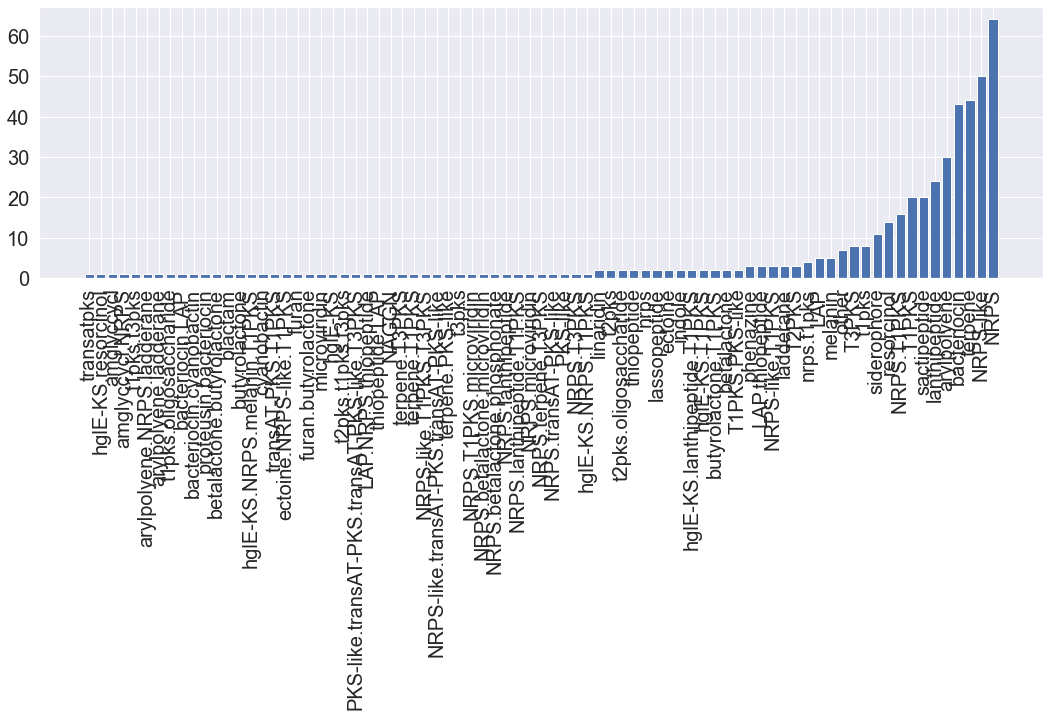

In [17]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(18,5))

plt.bar(metadata_sum['Type'],metadata_sum['Count'])
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
# metadata_sum.plot.bar(x='Type')

## 4.7. Plotting GCF clustermap

In [18]:
cluster_list = []
strains = []

for item in gcf_dict.values():
    cluster_list = cluster_list + item

for item in cluster_list:
    if 'BGC' in item:
        strains.append('MIBiG')
    else:
        strains.append(item.split('.')[0])

col_names = list(np.unique(strains))

col_names

['ERR3941051_contigs',
 'ERR3941055_contigs',
 'ERR3941057_contigs',
 'ERR3941059_contigs',
 'ERR3941060_contigs',
 'ERR3941062_contigs',
 'ERR3941063_contigs',
 'ERR3941065_contigs',
 'ERR3941067_contigs',
 'ERR3941069_contigs',
 'ERR3941071_contigs',
 'ERR3941072_contigs',
 'ERR3941073_contigs',
 'ERR3941074_contigs',
 'ERR3941075_contigs',
 'ERR3941076_contigs',
 'ERR3941077_contigs',
 'ERR3941079_contigs',
 'ERR3941080_contigs',
 'ERR3941082_contigs',
 'ERR3941083_contigs',
 'ERR3941084_contigs',
 'ERR3941085_contigs',
 'ERR3941087_contigs',
 'ERR3941088_contigs',
 'ERR3941090_contigs',
 'ERR3941091_contigs',
 'ERR3941092_contigs',
 'ERR3941093_contigs',
 'ERR3941094_contigs',
 'ERR3941095_contigs',
 'ERR3941097_contigs',
 'ERR3941098_contigs',
 'ERR3941100_contigs',
 'ERR3941101_contigs',
 'ERR3941102_contigs',
 'ERR3941103_contigs',
 'ERR3941104_contigs',
 'ERR3941106_contigs',
 'ERR3941107_contigs',
 'ERR3941108_contigs',
 'ERR3941109_contigs',
 'ERR3941110_contigs',
 'ERR394111

In [19]:
family_rows = []
indexes = []

for key,value in gcf_dict.items():
    indexes.append(key)
    row = []
    for strain in col_names:
        if strain == "MIBiG":
            find_substring_in_list = [s for s in value if "BGC" in s]
            sublist = filter(lambda x: "BGC" in x, value)
        else:
            find_substring_in_list = [s for s in value if strain.lower() in s.lower()] # .lower() for case insensitive
            sublist = filter(lambda x: strain in x, value)
            for item in find_substring_in_list:
                if 'BGC' in item:
                    find_substring_in_list.remove(item)
                    sublist.remove(item)
        if find_substring_in_list:
            row.append(sublist)
        else:
            row.append(0)
    family_rows.append(row)
    
gcf_patterns = pd.DataFrame(family_rows,columns=col_names,index=indexes)

In [20]:
family_counts = []

for i,r in gcf_patterns.iterrows():
    new_row = []
    for item in r:
        if item == 0:
            new_row.append(0)
        else:
            new_row.append(1)
    family_counts.append(new_row)
    
gcf_binary = pd.DataFrame(family_counts,columns=col_names,index=indexes)

gcf_binary[:5]

,ERR3941051_contigs,ERR3941055_contigs,ERR3941057_contigs,ERR3941059_contigs,ERR3941060_contigs,ERR3941062_contigs,ERR3941063_contigs,ERR3941065_contigs,ERR3941067_contigs,ERR3941069_contigs,...,VIKV01,VIKW01,VIKX01,VIKY01,VIKZ01,VILB01,VILC01,VILD01,VILE01,VILF01
GCF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
GCF2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


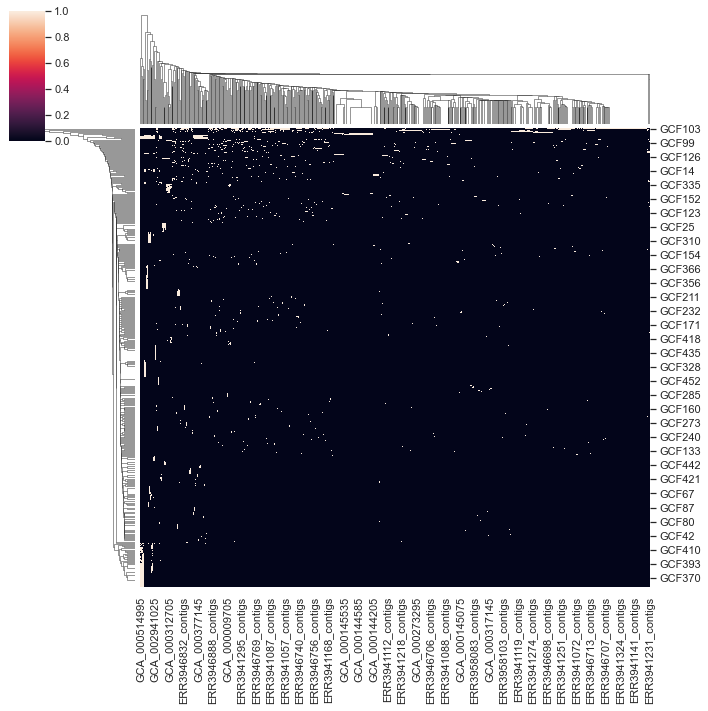

In [21]:
gcf_noMIBiG = gcf_binary[(gcf_binary.T != 0).any()].drop(columns='MIBiG')

sns.clustermap(gcf_noMIBiG)

In [22]:
metabgc_glob = glob.glob('/Volumes/TFL190831/ming_output/antismash/ERR*/c*.gbk')
meta_count = glob.glob('/Volumes/TFL190831/ming_output/antismash/ERR*/')

len(metabgc_glob)/len(meta_count)

6.758913412563667

In [23]:
genomes_glob = glob.glob('/Volumes/TFL190831/nf_output-iomega/*/*region*.gbk')
genomes_count = glob.glob('/Volumes/TFL190831/nf_output-iomega/*/')

len(genomes_glob)/len(genomes_count)

10.021505376344086